## Loading of amygdala data

includes some visualizations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [2]:
import pathlib
import h5py

In [3]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [6]:
c = pathlib.Path("../data/amygdala")
f_mat = list(data_path.rglob('*h5'))
f_mat

[PosixPath('../data/amygdala/data_NIX/Data_Subject_08_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_03_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_05_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_07_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_04_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_01_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_02_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_06_Session_01.h5'),
 PosixPath('../data/amygdala/data_NIX/Data_Subject_09_Session_01.h5')]

In [79]:
with h5py.File(f_mat[5], "r") as f:
    print(f.keys())
    print(f["data"]["Data_Subject_01_Session_01"]["multi_tags"].keys())
    spike_times = np.array(f["data"]["Data_Subject_01_Session_01"]["data_arrays"]["Spike_Times_Unit_1_uAL_1_Trial_14"]["data"])
    lfp = np.array(f["data"]["Data_Subject_01_Session_01"]["data_arrays"]["iEEG_Data_Trial_14"]["data"])

<KeysViewHDF5 ['data', 'metadata']>
<KeysViewHDF5 ['Multitag_Spike_Times_Unit_1_uAL_1_Trial_01', 'Multitag_Spike_Times_Unit_2_uAL_2_Trial_01', 'Multitag_Spike_Times_Unit_3_uAL_6_Trial_01', 'Multitag_Spike_Times_Unit_4_uAR_7_Trial_01', 'Multitag_Spike_Times_Unit_1_uAL_1_Trial_02', 'Multitag_Spike_Times_Unit_2_uAL_2_Trial_02', 'Multitag_Spike_Times_Unit_3_uAL_6_Trial_02', 'Multitag_Spike_Times_Unit_4_uAR_7_Trial_02', 'Multitag_Spike_Times_Unit_1_uAL_1_Trial_03', 'Multitag_Spike_Times_Unit_2_uAL_2_Trial_03', 'Multitag_Spike_Times_Unit_3_uAL_6_Trial_03', 'Multitag_Spike_Times_Unit_4_uAR_7_Trial_03', 'Multitag_Spike_Times_Unit_1_uAL_1_Trial_04', 'Multitag_Spike_Times_Unit_2_uAL_2_Trial_04', 'Multitag_Spike_Times_Unit_3_uAL_6_Trial_04', 'Multitag_Spike_Times_Unit_4_uAR_7_Trial_04', 'Multitag_Spike_Times_Unit_1_uAL_1_Trial_05', 'Multitag_Spike_Times_Unit_2_uAL_2_Trial_05', 'Multitag_Spike_Times_Unit_3_uAL_6_Trial_05', 'Multitag_Spike_Times_Unit_4_uAR_7_Trial_05', 'Multitag_Spike_Times_Unit_1_

In [81]:
min_isi = np.diff(spike_times).min()
min_isi

0.0058437500000003695

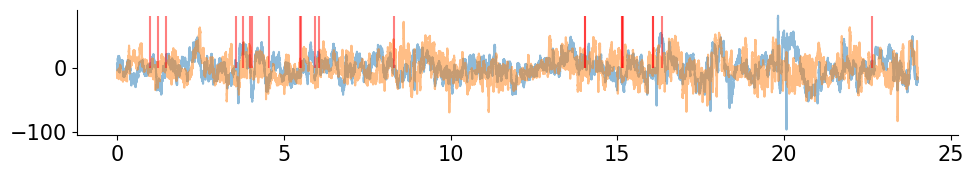

In [66]:
plt.figure(figsize=(10,2))
plt.plot(np.linspace(0, 24, lfp.shape[-1]), lfp.T, alpha=0.5)
plt.vlines(spike_times, 0, lfp.max(), "r", alpha=0.5)
plt.show()